# Feature Correlation Analysis

This notebook helps search for any correlation between gene expression and copy number status. Samples are split into subgroups (normal, amplified, deleted) to isolate any patterns in gene expression data related to copy number status.

The following samples are used:
- C3L-02705-71
- C3N-00148-01
- C3N-00148-04

Note that there is a class imbalance among the samples, where normal and amplified results are much more strongly represented than deleted ones.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Retrieve copy number and gene expression data for each sample:

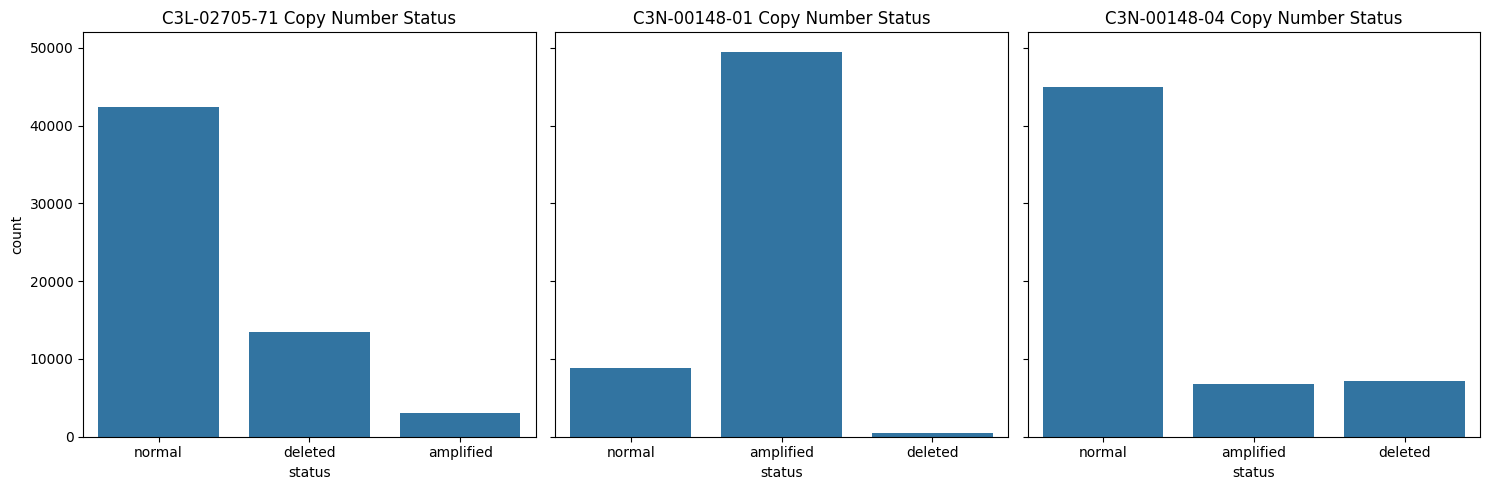

In [7]:
s1_case_id = 'C3L-02705-71'
s2_case_id = 'C3N-00148-01'
s3_case_id = 'C3N-00148-04'

# load datasets
s1_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3L-02705-71.csv')
s2_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3N-00148-01.csv')
s3_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3N-00148-04.csv')

# set up figure and axes for plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# plot for sample 1
sns.countplot(data=s1_df, x='status', ax=axes[0])
axes[0].set_title(f'{s1_case_id} Copy Number Status')

# plot for sample 2
sns.countplot(data=s2_df, x='status', ax=axes[1])
axes[1].set_title(f'{s2_case_id} Copy Number Status')

# plot for sample 3
sns.countplot(data=s3_df, x='status', ax=axes[2])
axes[2].set_title(f'{s3_case_id} Copy Number Status')

# side by side display
plt.tight_layout()
plt.show()

Description lists for plots

In [12]:
samples = [s1_df, s2_df, s3_df]
sample_names = ["s1", "s2", "s3"]
stats = ['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']

# status to color mapping
status_colors = {
    "normal": "green",
    "amplified": "blue",
    "deleted": "red"
}

Separate out the dataframes and display their gene expression statistics

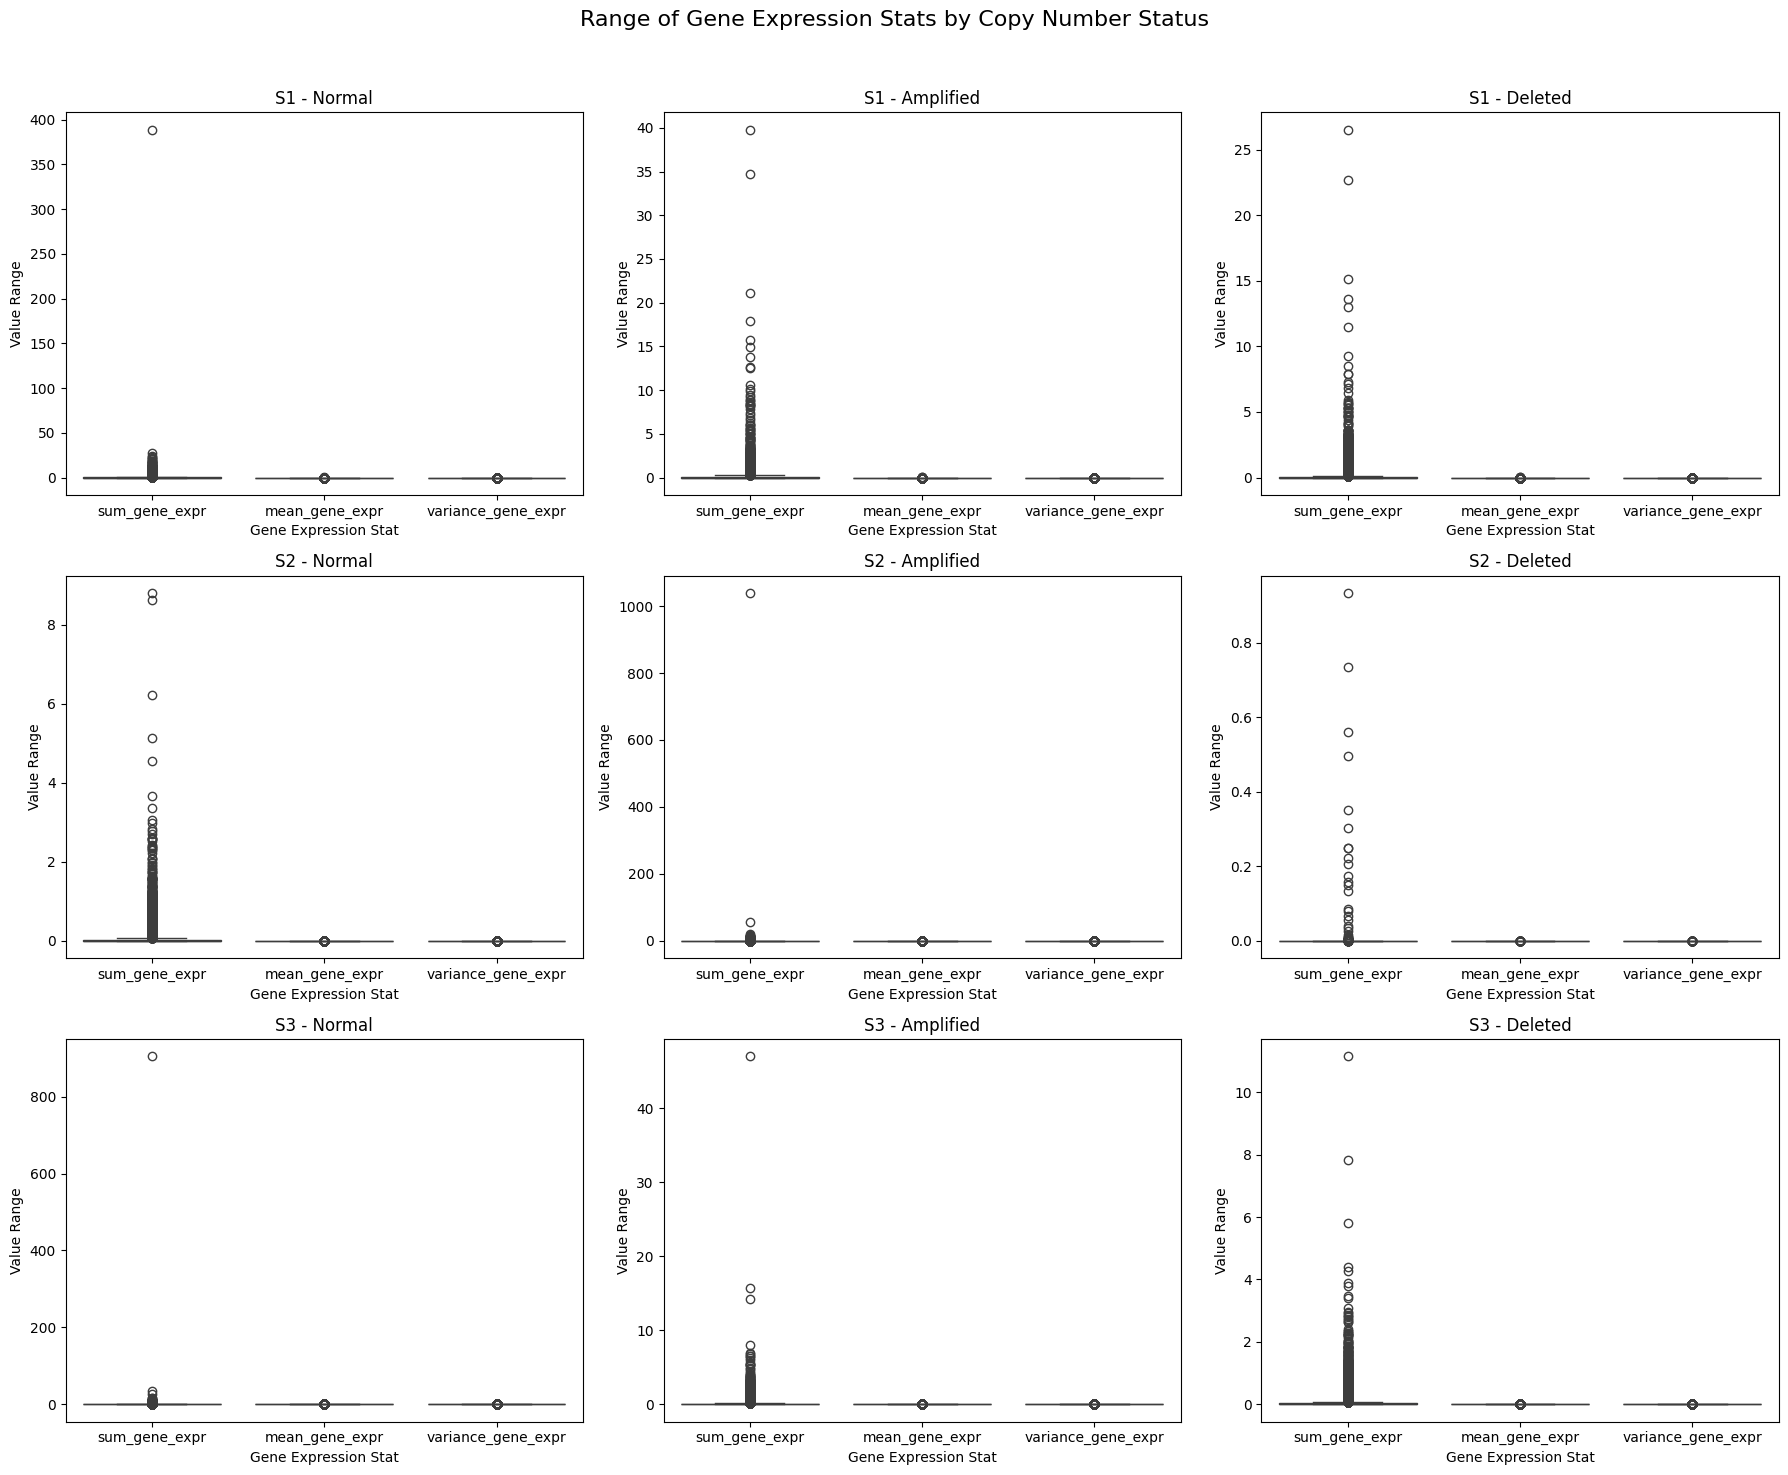

In [13]:
# 3x3 grid of subplots for 9 plots total
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Range of Gene Expression Stats by Copy Number Status', fontsize=16)

for i, (sample_df, sample_name) in enumerate(zip(samples, sample_names)):
    # split each df by status
    norm_df = sample_df[sample_df['status'] == 'normal']
    amp_df = sample_df[sample_df['status'] == 'amplified']
    del_df = sample_df[sample_df['status'] == 'deleted']

    # lists of data and titles
    status_dfs = [norm_df, amp_df, del_df]
    statuses = ["Normal", "Amplified", "Deleted"]

    # for each status-specific df, create a boxplot of gene expression stats
    for j, (status_df, status) in enumerate(zip(status_dfs, statuses)):
        sns.boxplot(data=status_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']], ax=axes[i, j])
        axes[i, j].set_title(f"{sample_name.upper()} - {status}")
        axes[i, j].set_xlabel("Gene Expression Stat")
        axes[i, j].set_ylabel("Value Range")

# prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjusts layout to fit within figure area with title
plt.show()

Separate histograms for clearer view of the varying distribution ranges

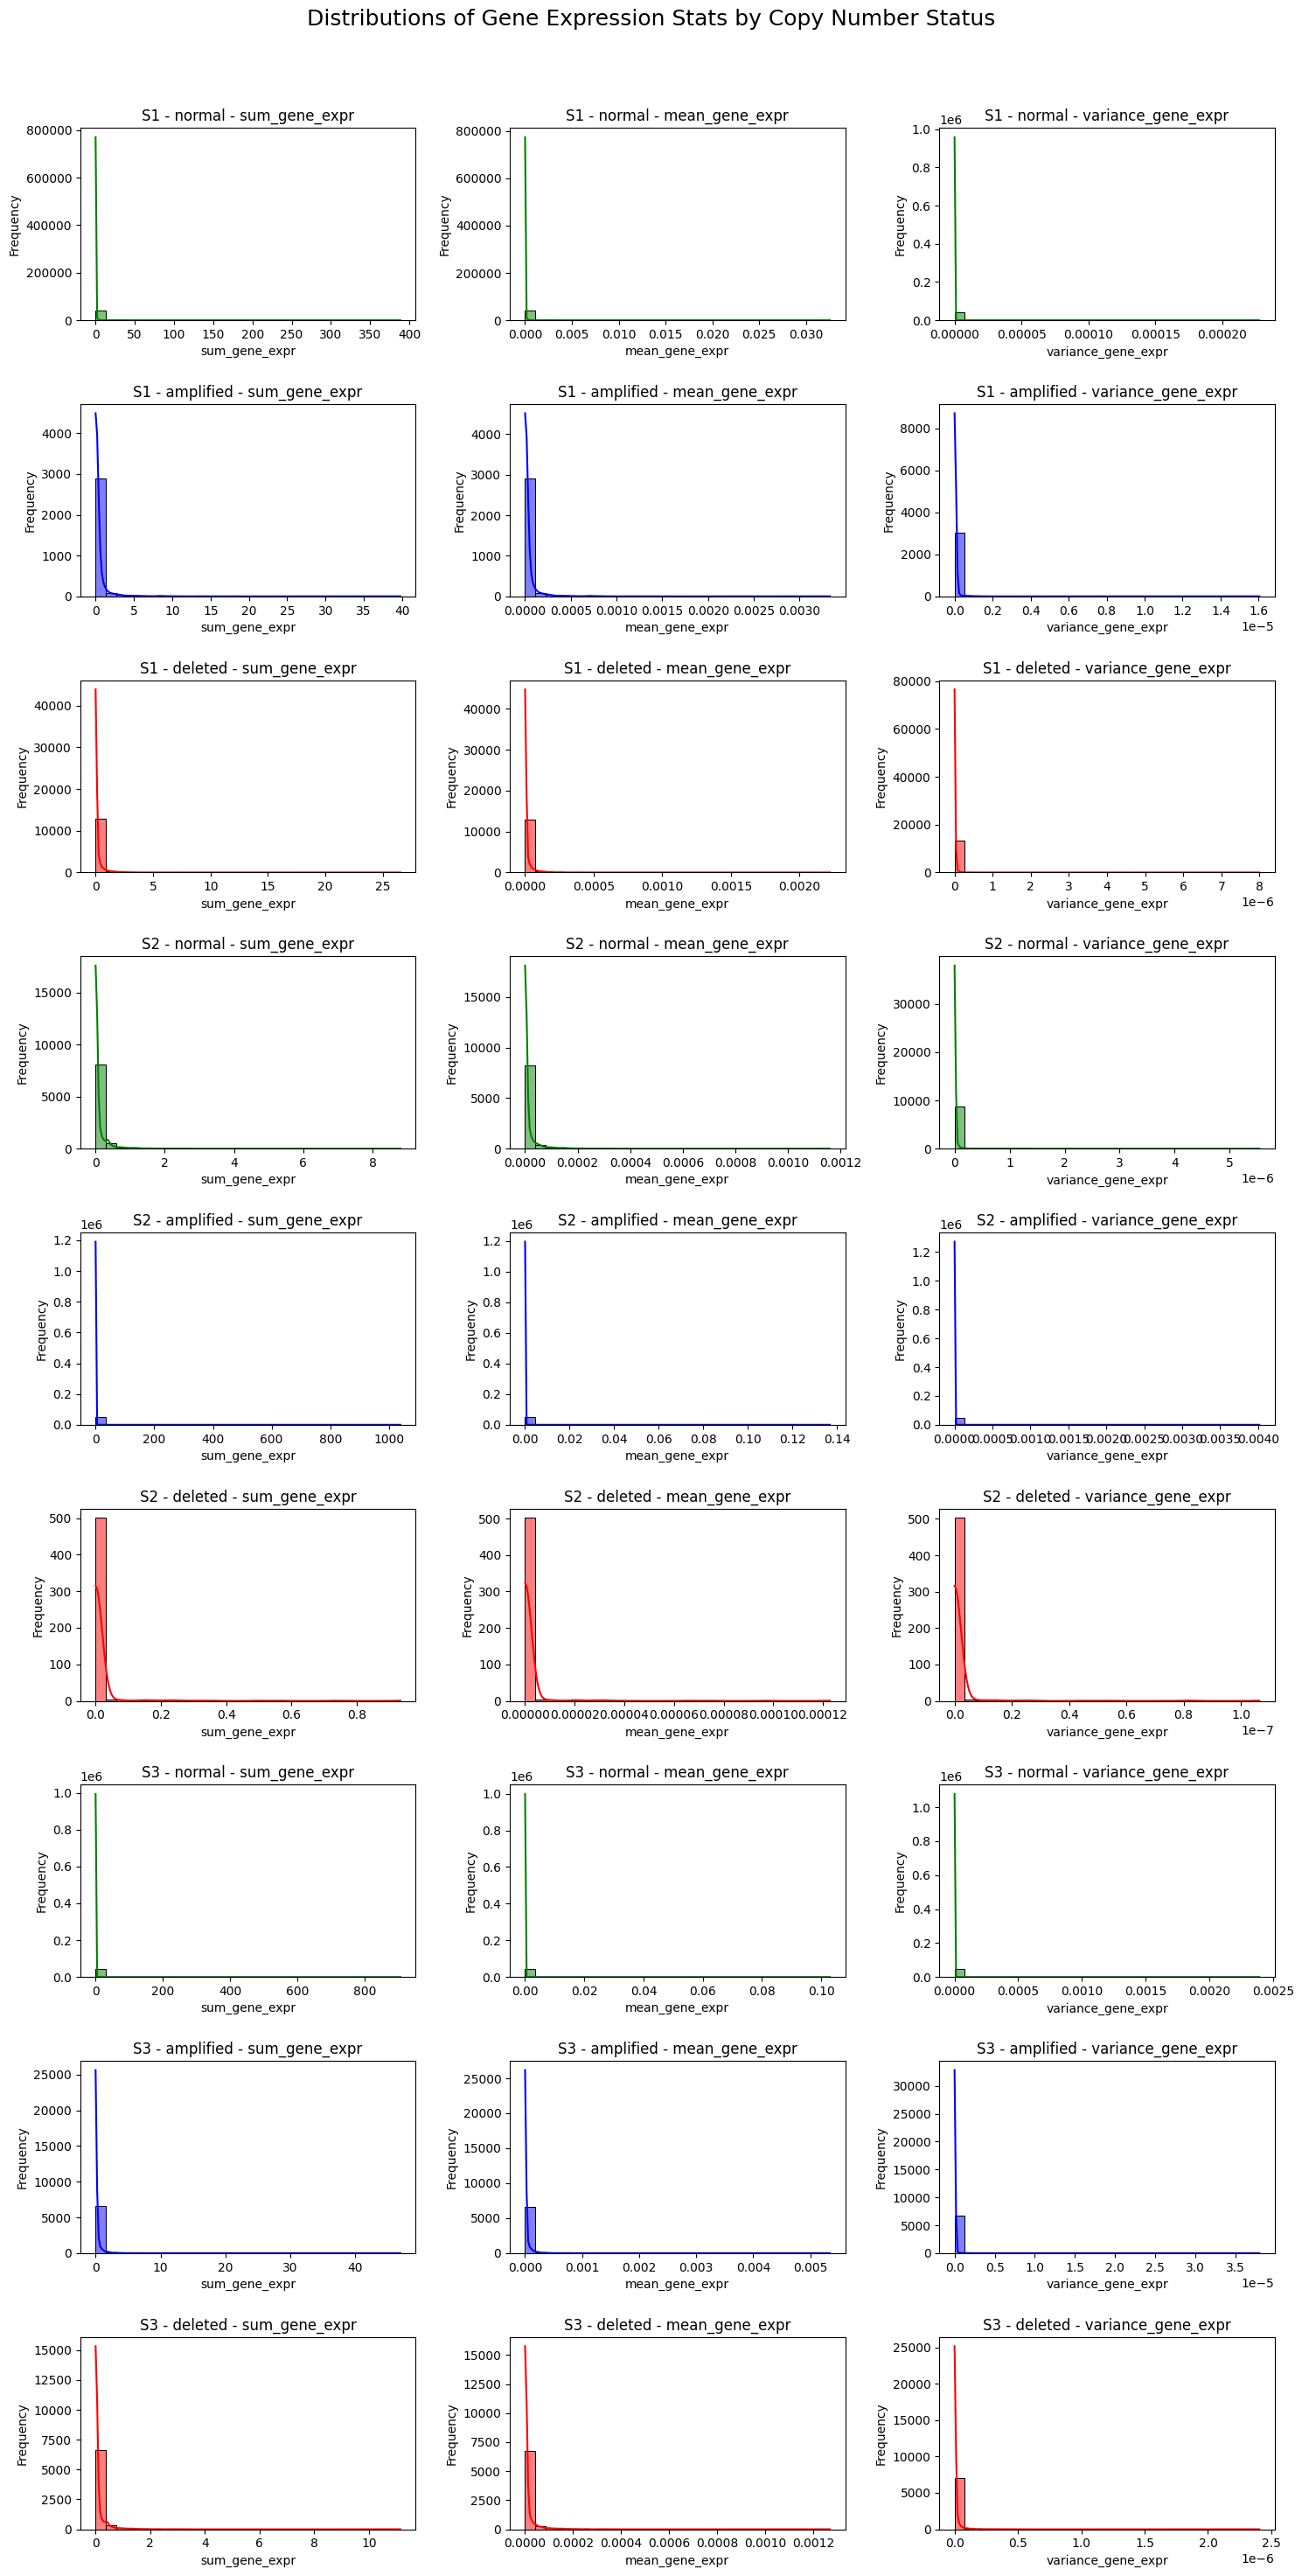

In [14]:
# 9x3 grid of subplots for 27 plots total
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
fig.suptitle('Distributions of Gene Expression Stats by Copy Number Status', fontsize=18)

for i, (sample_df, sample_name) in enumerate(zip(samples, sample_names)):
    # split each df by status
    norm_df = sample_df[sample_df['status'] == 'normal']
    amp_df = sample_df[sample_df['status'] == 'amplified']
    del_df = sample_df[sample_df['status'] == 'deleted']

    # lists of data and titles
    status_dfs = [norm_df, amp_df, del_df]
    statuses = ["normal", "amplified", "deleted"]

    # for each status-specific df, create histograms for each statistic
    for j, (status_df, status) in enumerate(zip(status_dfs, statuses)):
        for k, stat in enumerate(stats):
            sns.histplot(status_df[stat], bins=30, kde=True, ax=axes[i * 3 + j, k], color=status_colors[status])
            axes[i * 3 + j, k].set_title(f"{sample_name.upper()} - {status} - {stat}")
            axes[i * 3 + j, k].set_xlabel(stat)
            axes[i * 3 + j, k].set_ylabel("Frequency")

# prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjusts layout to fit within figure area with title
plt.show()

Interquartile range calculation to remove outliers

In [16]:
# helper function to remove outliers via IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

Using the same histogram scheme as above, displaying log transformed distributions

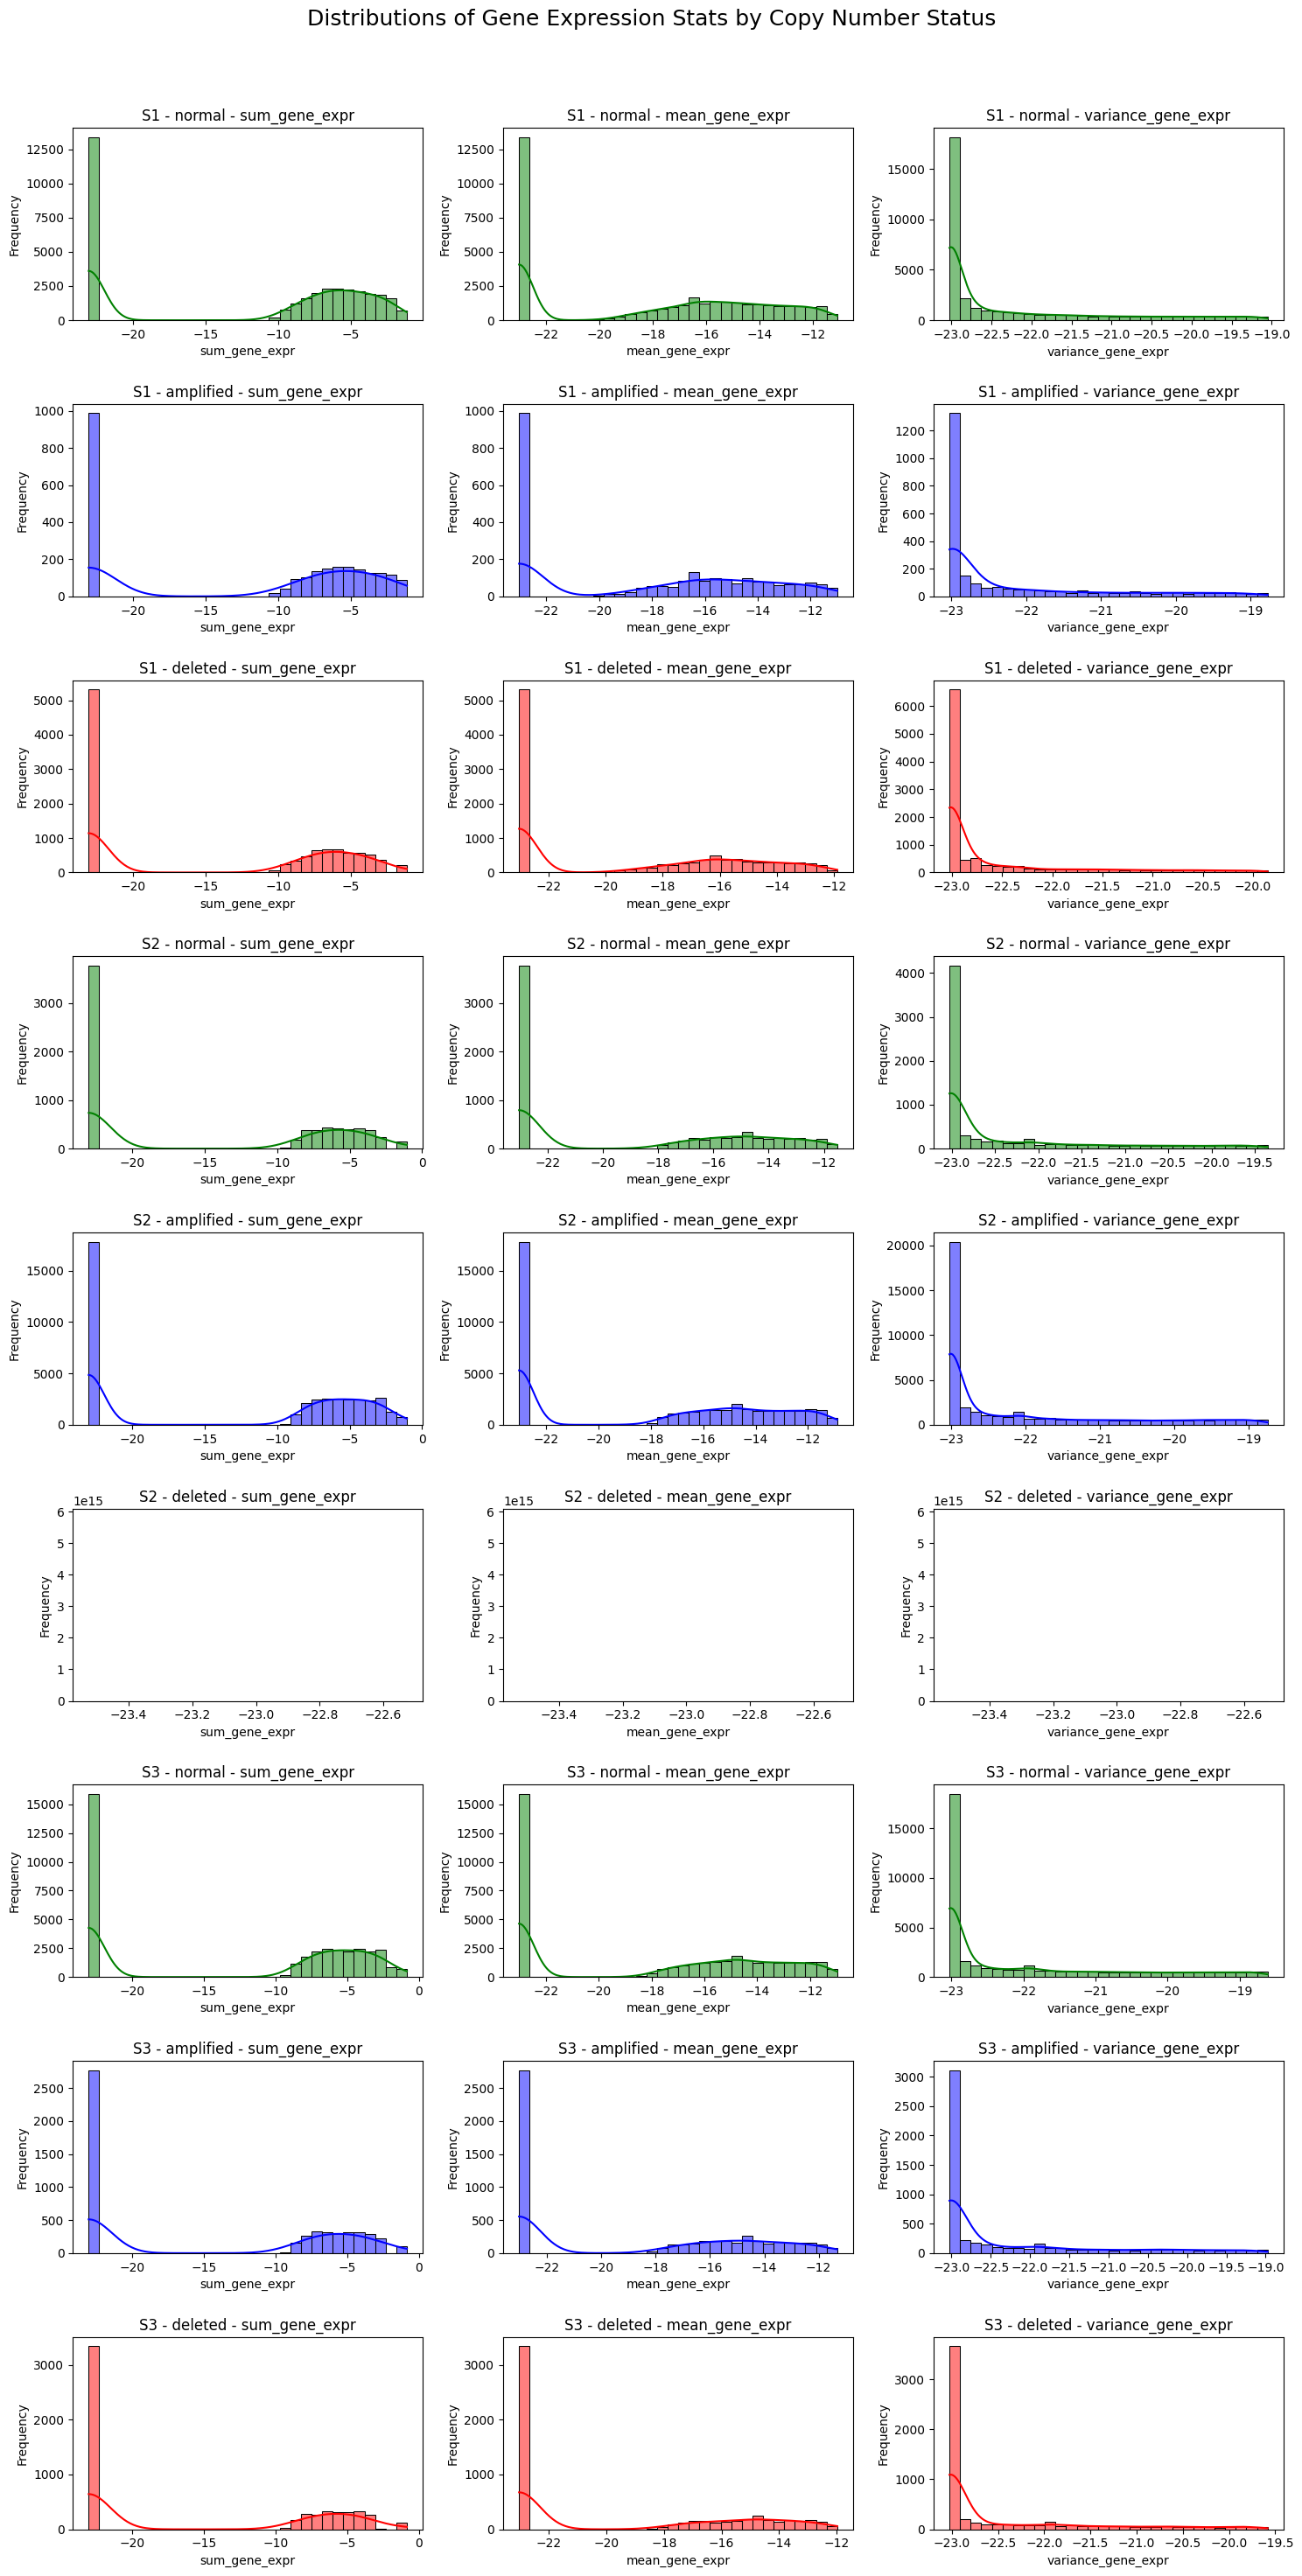

In [23]:
# 9x3 grid of subplots for 27 plots total
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
fig.suptitle('Distributions of Gene Expression Stats by Copy Number Status', fontsize=18)

for i, (sample_df, sample_name) in enumerate(zip(samples, sample_names)):
    # split each df by status
    norm_df = sample_df[sample_df['status'] == 'normal']
    amp_df = sample_df[sample_df['status'] == 'amplified']
    del_df = sample_df[sample_df['status'] == 'deleted']

    for column in stats:
        norm_df_cleaned = norm_df.copy()
        norm_df_cleaned = remove_outliers_iqr(norm_df_cleaned, column)
        amp_df_cleaned = amp_df.copy()
        amp_df_cleaned = remove_outliers_iqr(amp_df_cleaned, column)
        del_df_cleaned = del_df.copy()
        del_df_cleaned = remove_outliers_iqr(del_df_cleaned, column)

    # lists of data and titles
    status_dfs = [norm_df, amp_df, del_df]
    status_dfs_cleaned = [norm_df_cleaned, amp_df_cleaned, del_df_cleaned]
    statuses = ["normal", "amplified", "deleted"]

    # for each status-specific df, create histograms for each statistic
    for j, (status_df, status) in enumerate(zip(status_dfs_cleaned, statuses)):
        for k, stat in enumerate(stats):
            # data = np.log1p(status_df[stat])
            data = np.log(status_df[stat] + 1e-10) # small constant for zero values

            sns.histplot(data, bins=30, kde=True, ax=axes[i * 3 + j, k], color=status_colors[status])
            axes[i * 3 + j, k].set_title(f"{sample_name.upper()} - {status} - {stat}")
            axes[i * 3 + j, k].set_xlabel(stat)
            axes[i * 3 + j, k].set_ylabel("Frequency")

# prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjusts layout to fit within figure area with title
plt.show()